In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019.csv',encoding='latin-1',index_col=[0])
modeldf2021 = pd.read_csv('mydata/MMSA2021.csv',encoding='latin-1',index_col=[0])

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 179 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  210771 non-null  int64  
 1    STATERE1  71738 non-null   float64
 2    CELPHONE  71738 non-null   float64
 3    LADULT1   71738 non-null   float64
 4    COLGSEX   21 non-null      float64
 5    LANDSEX   30365 non-null   float64
 6    RESPSLCT  36285 non-null   float64
 7    SAFETIME  139033 non-null  float64
 8    CADULT1   139033 non-null  float64
 9    CELLSEX   139026 non-null  float64
 10   HHADULT   139028 non-null  float64
 11   SEXVAR    210771 non-null  int64  
 12   GENHLTH   210753 non-null  float64
 13   PHYSHLTH  210750 non-null  float64
 14   MENTHLTH  210761 non-null  float64
 15   POORHLTH  116171 non-null  float64
 16   HLTHPLN1  210764 non-null  float64
 17   PERSDOC2  210765 non-null  float64
 18   MEDCOST   210765 non-null  float64
 19   CHECKUP1  210763 non-

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  227792 non-null  int64  
 1    STATERE1  55524 non-null   float64
 2    CELPHON1  55524 non-null   float64
 3    LADULT1   55524 non-null   float64
 4    COLGSEX   18 non-null      float64
 5    LANDSEX   23345 non-null   float64
 6    RESPSLCT  30824 non-null   float64
 7    SAFETIME  172268 non-null  float64
 8    CADULT1   172268 non-null  float64
 9    CELLSEX   172267 non-null  float64
 10   HHADULT   172267 non-null  float64
 11   SEXVAR    227792 non-null  int64  
 12   GENHLTH   227790 non-null  float64
 13   PHYSHLTH  227790 non-null  float64
 14   MENTHLTH  227792 non-null  int64  
 15   POORHLTH  122851 non-null  float64
 16   PRIMINSR  227791 non-null  float64
 17   PERSDOC3  227792 non-null  int64  
 18   MEDCOST1  227791 non-null  float64
 19   CHECKUP1  227792 non-

### Converting 2019 BRFSS Dataframe Columns to appropriate datatype

In [10]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [11]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [12]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': '_HLTHPLN','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [13]:
#Convert Exercise variable to float
modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)
modeldf2021['_TOTINDA'] = modeldf2021['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

#we will drop this column as it has be adequately interpreted in the DROCDY3_ column
modeldf2019.drop(columns='ALCDAY5',inplace=True)
modeldf2021.drop(columns='ALCDAY5',inplace=True)

In [14]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# 2021 indexed with common columns
brfss_df = modeldf2021[common_columns]


### Lets clean up 2019 dataset and keep as training datset

In [15]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC',
                "CHECKUP1","CVDSTRK3","CHCSCNCR","CHCOCNCR","ADDEPEV3","CHCKDNY2", "DIABETE4",'_RACE',]


# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [16]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 134 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  227792 non-null  category
 1    STATERE1  55524 non-null   category
 2    LADULT1   55524 non-null   category
 3    COLGSEX   18 non-null      category
 4    LANDSEX   23345 non-null   category
 5    RESPSLCT  30824 non-null   category
 6    SAFETIME  172268 non-null  category
 7    CADULT1   172268 non-null  category
 8    CELLSEX   172267 non-null  category
 9    HHADULT   172267 non-null  float64 
 10   SEXVAR    227792 non-null  category
 11   GENHLTH   227790 non-null  category
 12   PHYSHLTH  227790 non-null  category
 13   MENTHLTH  227792 non-null  category
 14   POORHLTH  122851 non-null  float64 
 15   _HLTHPLN  227792 non-null  category
 16   MEDCOST1  227791 non-null  category
 17   CHECKUP1  227792 non-null  category
 18   BPMEDS    84782 non-null   category
 19   

In [17]:
#Lets make a copy of the 2021 DATAFRAME
processed_features_df = brfss_df.copy()

#Place decimal place in columns where decimal place is implied 
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5','_DRNKWK1']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [18]:
processed_features_df.drop(columns='MMSANAME',inplace=True)

#### REPLACE NUMERIC CATEGORICAL COLUMNS WITH ACTUAL CATEGORIES FROM QUESTIONNAIRE 

In [19]:
diabetes_replace = {1:'yes', 2:'yes', 3:'no', 4:'yes', 7:np.nan, 9:np.nan}
income_replace = {1:'<15k', 2:'15k-25k', 3:'25k-35k', 4:'35k-50k', 5:'>50k',9:np.nan}

race_replace = {1:'white', 2:'black', 3:'native american', 4:'asian', 5:'native hawaiian/pacific islander', 
                6:'other race only', 7:'multiracial', 8:'hispanic', 9:np.nan}

prace_replace = {1:'white', 2:'black', 3:'native american', 4:'asian', 5:'native hawaiian/pacific islander', 
                6:'other race', 7:'no_preference race', 77:np.nan, 99:np.nan}

mrace_replace = {1:'whiteonly', 2:'blackonly', 3:'native american_alaskanonly', 4:'asianonly', 
                 5:'native hawaiian/pacific islander', 
                6:'otherraceonly', 7:'multiracial', 77:'notsure', 9:np.nan}

racegr3_replace = {1:'White only, Non-Hispanic' , 2:'Black only, Non-Hispanic' ,  
                    3:'Other race only, Non-Hispanic' ,  4:'Multiracial, Non-Hispanic' ,5:'Hispanic',9:np.nan}

age_replace = {1:'18-24', 2:'25-29', 3:'30-34', 4:'35-39', 5:'40-44', 6:'45-49', 7:'50-54', 8:'55-59', 9:'60-64', 
               10:'65-69', 11:'70-74', 12:'75-79', 13:'80+', 14:np.nan}

employ_replace = {1:'Employed for wages',2:'self employed',3:'Out of work for 1 year or more'
                  ,4:'Out of work for less than 1 year',5:'homemaker', 6:'Student',
                  7:'Retired', 8:'Unable',9:np.nan}
age80_replace = {1:'18-24', 2:'25-34', 3:'35-44', 4:'45-54', 5:'55-64',6:'65&older'}

age65yr_replace = {1:'18-64',2:'65&older',3:np.nan}
sex_replace = {1:'male', 2:'female'}
heart_disease_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
heart_attack_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
stroke_replace =  {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
general_health_replace = {1:'excellent', 2:'very good', 3:'good', 4:'fair', 5:'poor', 7:np.nan, 9:np.nan}
rfhealth_replace ={1:'Good or Better Health',2:'fair or poor health',9:np.nan}
physical_health_replace = {88: 0, 77: np.nan, 99: np.nan}
mental_health_replace = {88: 0, 77: np.nan, 99: np.nan}
educa_replace = {1:'none', 2:'HS_diploma', 3:'Attended_Col', 4:'College_grad',9:np.nan}
#doctor_replace = {1:'yes', 2:'yes', 3:'no', 7:np.nan, 9:np.nan}
medical_costs_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
hiv_replace = {1:'yes', 2:'no',9:np.nan}
checkup_replace = {1:'1 year', 2:'2 years', 3:'5 years', 4:'>5 years', 7:'unknown', 8:'never', 9:np.nan}
exercise_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
marital_replace = {1:'married', 2:'divorced', 3:'widowed', 4:'separated', 5:'single', 6:'living together', 9:np.nan}
education_replace = {1:'none', 2:'1-8', 3:'9-11', 4:'12/ged', 5:'c1-3', 6:'cg', 9:np.nan}
smoking_replace = {1:'yes', 2:'yes', 3:'no', 7:np.nan, 9:np.nan}
smoke100_replace = {1:'yes',2:'no', 7:np.nan, 9:np.nan}
usenow_replace = {1:'everyday',2:'somedays',3:'never',7:np.nan, 9:np.nan}
smoke3_replace = {1:'current-everyday',2:'current-somedays',3:'former',4:'never',9:np.nan}


alcohol_replace = {777:'yes', 888:'no', 999:'no'}
binge_replace = {1:'yes', 2:'no',9:np.nan}
cholesterol_replace = {1:'no',2:'yes',9:np.nan}
toldasthma_replace = {1:'no',2:'yes',9:np.nan}
asthma_replace = {1:'current',2:'former',3:'Never',9:np.nan}
bmicat_replace = {1:'Underweight',2:'Normal Weight',3:'Overweight',4:'Obese',}
childcat_replace ={1:'No children in household',2:'One child in household',3:"Two children in household",
                   4:'Three children in household',5:'Four children in household',
                   6:'Five or more children in household',9:np.nan}
race21_replace = {1:'Non-Hispanic White',2:'Non-White or Hispanic',9:np.nan}
blind_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
highblood_pressure = {1:'no',2:'yes',9:np.nan}
shot_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
difficult_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
health_plan_replace = {1:'yes',2:'no',7:np.nan,9:np.nan}
renthome_replace = {1:'own',2:'rent',3:'other_arrangement',7:np.nan,9:np.nan}
cellphone_replace = {8:0,7:np.nan,9:np.nan}


hhadult_replace = {77:np.nan, 99:np.nan}
health_days_replace = {88:0,77:np.nan, 99:np.nan}
children_replace = {88:0,99:np.nan}
hw_replace = {7777:np.nan, 9999:np.nan}
fruit_replace = {777:np.nan,555:0,9:np.nan}
hispanic_replace = {1:'yes', 2:'no',9:np.nan}
metric = True
max_weight = 999

#Categorical columns:

processed_features_df['_RFHYPE6'].replace(highblood_pressure,inplace=True)
processed_features_df['_RFBMI5'].replace(toldasthma_replace,inplace=True)
processed_features_df['_BMI5CAT'].replace(bmicat_replace,inplace=True)

processed_features_df['_LTASTH1'].replace(toldasthma_replace,inplace=True)
processed_features_df['_ASTHMS1'].replace(asthma_replace,inplace=True)
processed_features_df['_CASTHM1'].replace(toldasthma_replace,inplace=True)
processed_features_df['ASTHMA3'].replace(heart_attack_replace,inplace=True)
processed_features_df['ADDEPEV3'].replace(heart_attack_replace,inplace=True)

processed_features_df['CVDCRHD4'].replace(heart_attack_replace,inplace=True)
processed_features_df['CHCSCNCR'].replace(heart_attack_replace,inplace=True)
processed_features_df['CHCOCNCR'].replace(heart_attack_replace,inplace=True)
processed_features_df['CHCKDNY2'].replace(heart_attack_replace,inplace=True)
processed_features_df['_RFCHOL3'].replace(cholesterol_replace,inplace=True)


processed_features_df['_MICHD'].replace(heart_attack_replace,inplace=True)
processed_features_df['CVDINFR4'].replace(heart_attack_replace,inplace=True)
processed_features_df['CVDSTRK3'].replace(stroke_replace,inplace=True)

processed_features_df['_RFBING5'].replace(binge_replace,inplace=True)
processed_features_df['SMOKDAY2'].replace(smoking_replace,inplace=True)
processed_features_df['SMOKE100'].replace(smoke100_replace,inplace=True)
processed_features_df['USENOW3'].replace(usenow_replace,inplace=True)
processed_features_df['_SMOKER3'].replace(smoke3_replace,inplace=True)
processed_features_df['_RFSMOK3'].replace(highblood_pressure,inplace=True)


processed_features_df['GENHLTH'].replace(general_health_replace,inplace=True)
processed_features_df['_RFHLTH'].replace(rfhealth_replace,inplace=True)
processed_features_df['PHYSHLTH'].replace(physical_health_replace,inplace=True)
processed_features_df['MENTHLTH'].replace(mental_health_replace,inplace=True)


processed_features_df['EXERANY2'].replace(exercise_replace,inplace=True)
processed_features_df['_TOTINDA'].replace(exercise_replace,inplace=True)
processed_features_df['_INCOMG1'].replace(income_replace,inplace=True)

processed_features_df['_RACE'].replace(race_replace,inplace=True)
processed_features_df['_MRACE1'].replace(mrace_replace,inplace=True)
processed_features_df['_PRACE1'].replace(prace_replace,inplace=True)
processed_features_df['_RACEGR3'].replace(racegr3_replace,inplace=True)

processed_features_df['_HISPANC'].replace(hispanic_replace,inplace=True)
processed_features_df['_AGEG5YR'].replace(age_replace,inplace=True)
processed_features_df['_AGE65YR'].replace(age65yr_replace,inplace=True)
processed_features_df['_AGE_G'].replace(age80_replace,inplace=True)

processed_features_df['_SEX'].replace(sex_replace,inplace=True)
processed_features_df['_IMPSEX'].replace(sex_replace,inplace=True)
processed_features_df['SEXVAR'].replace(sex_replace,inplace=True)

processed_features_df['HIVTST7'].replace(shot_replace,inplace=True)
processed_features_df['FLUSHOT7'].replace(shot_replace,inplace=True)
processed_features_df['PNEUVAC4'].replace(shot_replace,inplace=True)
processed_features_df['_AIDTST4'].replace(hiv_replace,inplace=True)


processed_features_df['HEIGHT3'].replace(hw_replace,inplace=True)
processed_features_df['WEIGHT2'].replace(hw_replace,inplace=True)
processed_features_df['DIABETE4'].replace(diabetes_replace,inplace=True)
processed_features_df['_RACEG21'].replace(race21_replace,inplace=True)

processed_features_df['BLIND'].replace(blind_replace,inplace=True)
processed_features_df['DEAF'].replace(blind_replace,inplace=True)
processed_features_df['DIFFALON'].replace(difficult_replace,inplace=True)
processed_features_df['DIFFDRES'].replace(difficult_replace,inplace=True)
processed_features_df['DECIDE'].replace(difficult_replace,inplace=True)
processed_features_df['DIFFWALK'].replace(difficult_replace,inplace=True)
processed_features_df['VETERAN3'].replace(difficult_replace,inplace=True)

processed_features_df['RENTHOM1'].replace(renthome_replace,inplace=True)
processed_features_df['_EDUCAG'].replace(educa_replace,inplace=True)
processed_features_df['EDUCA'].replace(education_replace,inplace=True)
processed_features_df['_HLTHPLN'].replace(health_plan_replace,inplace=True)
processed_features_df['_RFDRHV7'].replace(highblood_pressure,inplace=True)
processed_features_df['CHECKUP1'].replace(checkup_replace,inplace=True)
processed_features_df['MEDCOST1'].replace(medical_costs_replace,inplace=True)
processed_features_df['MARITAL'].replace(marital_replace,inplace=True)
processed_features_df['EMPLOY1'].replace(employ_replace,inplace=True)



#numerical columns:
processed_features_df['PHYSHLTH'].replace(health_days_replace,inplace=True)
processed_features_df['MENTHLTH'].replace(health_days_replace,inplace=True)
processed_features_df['POORHLTH'].replace(health_days_replace,inplace=True)
processed_features_df['HHADULT'].replace(hhadult_replace,inplace=True)
processed_features_df['CHILDREN'].replace(children_replace,inplace=True)
processed_features_df['CPDEMO1B'].replace(cellphone_replace,inplace=True)



column_names = ["FRUIT2", "FRUITJU2", "FVGREEN1", "FRENCHF1", "POTATOE1", "VEGETAB2"]

for column in column_names:
    processed_features_df[column].replace(fruit_replace, inplace=True)

### Generate EDA Report with Original Dataset

In [20]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2021.html")

### Handle Missing data

In [21]:
pd.reset_option('display.max_rows',None)

In [22]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   227774  0.999921
NUMPHON3  211707  0.929387
LANDSEX   204447  0.897516
CAGEG     201128  0.882946
DIABAGE3  199821  0.877208
RESPSLCT  196968  0.864684
ASTHNOW   195581  0.858595
PREGNANT  182883  0.802851
NUMHHOL3  172269  0.756256
STATERE1  172268  0.756251
LADULT1   172268  0.756251
LMTJOIN3  158813  0.697184
ARTHDIS2  158813  0.697184
ARTHEDU   158813  0.697184
ARTHEXER  158813  0.697184
JOINPAI2  158813  0.697184
HIVTSTD3  155405  0.682223
_FLSHOT7  149524  0.656406
_PNEUMO3  149524  0.656406
SMOKDAY2  145647  0.639386
BPMEDS    143010  0.627810
FLSHTMY3  115386  0.506541
MAXDRNKS  113755  0.499381
DRNK3GE5  113425  0.497932
AVEDRNK3  113057  0.496317
POORHLTH  107547  0.472128
HHADULT    57075  0.250558
CELLSEX    55525  0.243753
CADULT1    55524  0.243749
SAFETIME   55524  0.243749
_INCOMG1   50442  0.221439
PNEUVAC4   35952  0.157828
_VEGESU1   32613  0.143170
_RFCHOL3   31620  0.138811
HIVTST7    28290  0.124192
_AIDTST4   28290  0.124192
_

In [23]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 'Underweight'
    elif 18.50 <= _BMI5 < 25.00:
        return 'Overweight'
    elif 25.00 <= _BMI5 < 30.00:
        return 'Normal'
    elif _BMI5 >= 30.00:
        return 'Obese'
    else:
        return np.nan  # Handle other possible cases (e.g. negative BMI or None)
    
def four_cat_bmi(_BMI5):
    if 12.00 <= _BMI5 < 25.00:
        
        return 'no'
    elif 25.00 <= _BMI5 < 99.99:
        
        return 'yes'
    else:
         np.nan

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_RFBMI5'] = processed_features_df['_BMI5'].apply(four_cat_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')


In [24]:
#Convert weight2 column to weight in pounds

def convert_to_pounds(value):
    # Convert kilograms (9000 - 9998) to pounds
    if 9000 <= value <= 9998:
        kg_weight = value % 9000  # More efficient way to remove the first digit
        return round(kg_weight * 2.20462, 2)

    # Handle unexpected values
    if value < 50 or value > 9998:
        return np.nan  
    
    # Assume the value is already in pounds
    return value

processed_features_df['WEIGHT2'] = processed_features_df['WEIGHT2'].apply(convert_to_pounds)

In [25]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unique values and may be of no importance to ones health
processed_features_df.drop(columns=['SAFETIME','CELLSEX',
                                    'SEQNO','CADULT1'],inplace=True)

#Drop these fruit/Veg columns as they have already been interpreted in other columns as per day from per day/week/month:
processed_features_df.drop(columns=['VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2'],inplace=True)

#CADULT1- Are you 18 years of age or older? if not survey was terminated hence everyone interviewed was 18yrs
#SAFETIME- Is this a safe time to talk with you?
#CELLSEX- Are you male or female? reflected by _SEX,SEXVAR,_IMPSEX
#SEQNO- its like an ID So it can be dropped

processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 97 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DISPCODE  227792 non-null  category
 1   HHADULT   170717 non-null  float64 
 2   SEXVAR    227792 non-null  object  
 3   GENHLTH   227191 non-null  object  
 4   PHYSHLTH  223101 non-null  float64 
 5   MENTHLTH  223781 non-null  float64 
 6   _HLTHPLN  218451 non-null  object  
 7   MEDCOST1  227061 non-null  object  
 8   CHECKUP1  227414 non-null  object  
 9   CVDINFR4  226383 non-null  object  
 10  CVDCRHD4  225759 non-null  object  
 11  CVDSTRK3  227061 non-null  object  
 12  ASTHMA3   226869 non-null  object  
 13  CHCSCNCR  227063 non-null  object  
 14  CHCOCNCR  227073 non-null  object  
 15  ADDEPEV3  226423 non-null  object  
 16  CHCKDNY2  226831 non-null  object  
 17  DIABETE4  227244 non-null  object  
 18  MARITAL   224819 non-null  object  
 19  EDUCA     226321 non-nu

In [26]:
processed_features_df['_SEX'].value_counts()

female    121357
male      106435
Name: _SEX, dtype: int64

In [27]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Fill missing heights with the mean height for each gender
processed_features_df['HEIGHT3'].fillna(processed_features_df.groupby('_SEX')['HEIGHT3'].transform('mean'), inplace=True)

In [28]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG
#'WEIGHT2' - Weight in pounds

# Replace missing values with the corresponding mean weight value
processed_features_df['WTKG3'].fillna(processed_features_df.groupby('_SEX')['WTKG3'].transform('mean'), inplace=True)

# Replace missing values with the corresponding mean weight value
processed_features_df['WEIGHT2'].fillna(processed_features_df.groupby('_SEX')['WEIGHT2'].transform('mean'), inplace=True)

In [29]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [30]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_',
]

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [31]:
#Replace Missing Income data with the median income per Race, sex,age and education 
medians = processed_features_df.groupby(['_RACE','_AGEG5YR','_SEX','_EDUCAG'])[col].transform('median')
processed_features_df['_INCOMG1'].fillna(medians, inplace=True)

<Axes: >

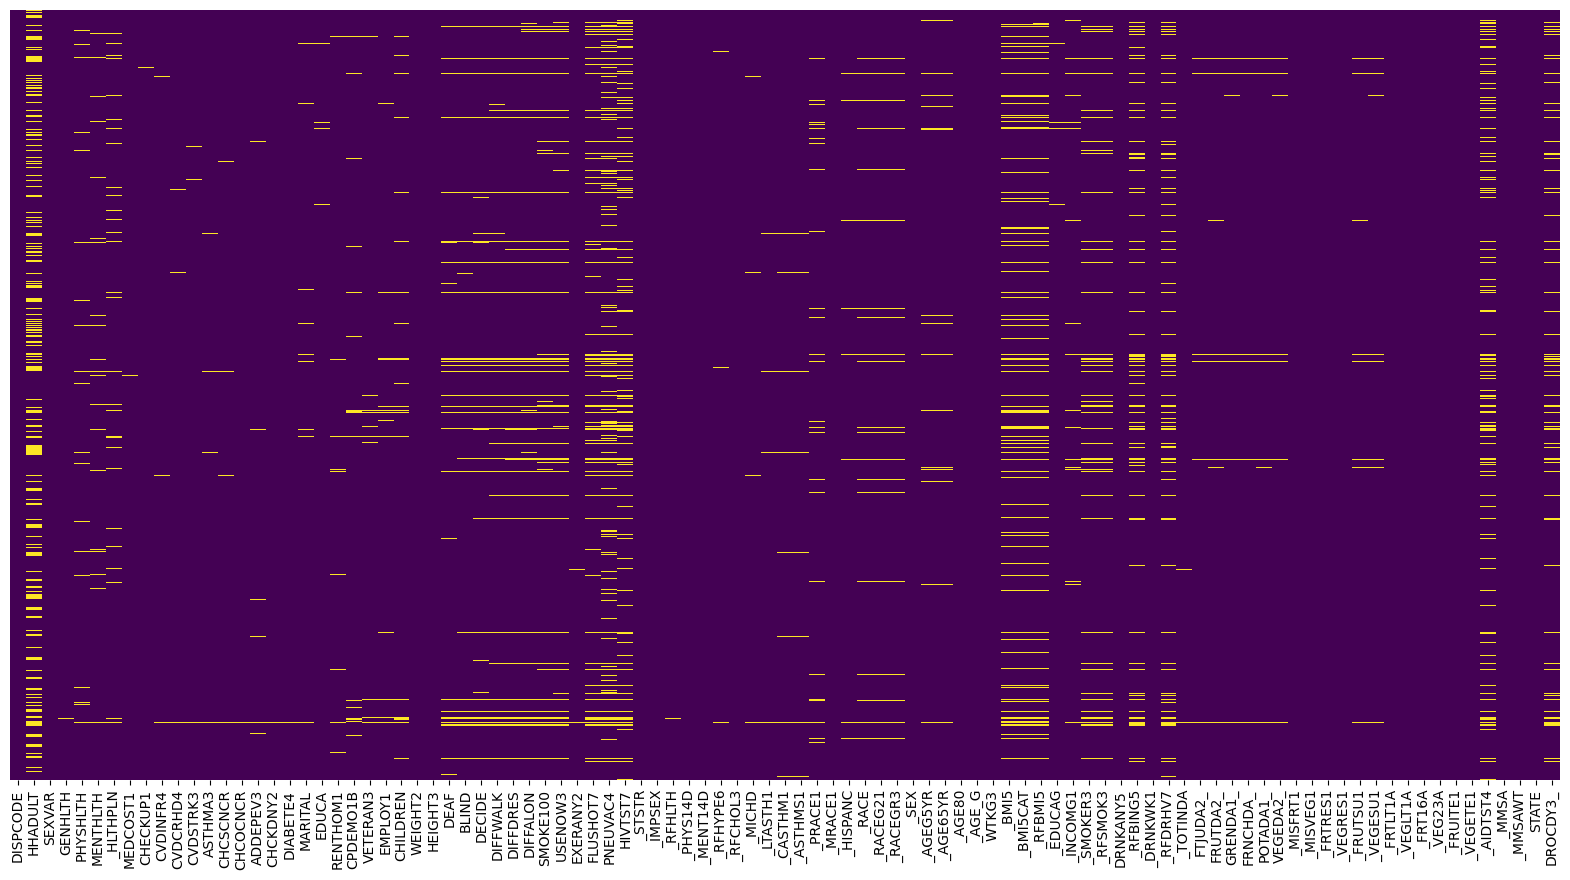

In [32]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [33]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
col_less5miss
processed_features_df.dropna(subset=col_less5miss,inplace=True)

total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data.to_string())

          Total   Percent
HHADULT   43573  0.243994
PNEUVAC4  19106  0.106987
_AIDTST4  12979  0.072678
HIVTST7   12979  0.072678
_RFBMI5    9762  0.054664
_BMI5CAT   9727  0.054468
_BMI5      9727  0.054468
_RFBING5   5762  0.032265
_RFDRHV7   5583  0.031263
FLUSHOT7   4625  0.025898
DROCDY3_   3955  0.022147
_SMOKER3   2028  0.011356
_RFSMOK3   2028  0.011356
SMOKE100   1898  0.010628
USENOW3    1338  0.007492
DIFFALON    659  0.003690
WTKG3         0  0.000000
_AGE_G        0  0.000000
_AGE80        0  0.000000
_AGE65YR      0  0.000000
_AGEG5YR      0  0.000000
_SEX          0  0.000000
_RACEGR3      0  0.000000
_EDUCAG       0  0.000000
_INCOMG1      0  0.000000
_RACEG21      0  0.000000
DRNKANY5      0  0.000000
_DRNKWK1      0  0.000000
_HISPANC      0  0.000000
_TOTINDA      0  0.000000
STATE         0  0.000000
_MMSAWT       0  0.000000
_MMSA         0  0.000000
_VEGETE1      0  0.000000
_FRUITE1      0  0.000000
_VEG23A       0  0.000000
_FRT16A       0  0.000000
_VEGLT1A    

In [34]:
#Drop rows where these columns are null
cols = list(missing_data.index[missing_data['Percent'] > 0])
processed_features_df.dropna(subset=cols,inplace=True)

In [35]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [36]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
processed_features_df.reset_index(drop=True, inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104619 entries, 0 to 104618
Data columns (total 97 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DISPCODE  104619 non-null  category
 1   HHADULT   104619 non-null  float64 
 2   SEXVAR    104619 non-null  object  
 3   GENHLTH   104619 non-null  object  
 4   PHYSHLTH  104619 non-null  float64 
 5   MENTHLTH  104619 non-null  float64 
 6   _HLTHPLN  104619 non-null  object  
 7   MEDCOST1  104619 non-null  object  
 8   CHECKUP1  104619 non-null  object  
 9   CVDINFR4  104619 non-null  object  
 10  CVDCRHD4  104619 non-null  object  
 11  CVDSTRK3  104619 non-null  object  
 12  ASTHMA3   104619 non-null  object  
 13  CHCSCNCR  104619 non-null  object  
 14  CHCOCNCR  104619 non-null  object  
 15  ADDEPEV3  104619 non-null  object  
 16  CHCKDNY2  104619 non-null  object  
 17  DIABETE4  104619 non-null  object  
 18  MARITAL   104619 non-null  object  
 19  EDUCA     104619 non-nu

In [37]:
#Convert all object variables to categories except STATE because it is text or high cardinality data;
for column in processed_features_df.columns:
    if column != 'STATE' and processed_features_df[column].dtype == 'object':
        processed_features_df[column] = processed_features_df[column].astype('category')
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104619 entries, 0 to 104618
Data columns (total 97 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DISPCODE  104619 non-null  category
 1   HHADULT   104619 non-null  float64 
 2   SEXVAR    104619 non-null  category
 3   GENHLTH   104619 non-null  category
 4   PHYSHLTH  104619 non-null  float64 
 5   MENTHLTH  104619 non-null  float64 
 6   _HLTHPLN  104619 non-null  category
 7   MEDCOST1  104619 non-null  category
 8   CHECKUP1  104619 non-null  category
 9   CVDINFR4  104619 non-null  category
 10  CVDCRHD4  104619 non-null  category
 11  CVDSTRK3  104619 non-null  category
 12  ASTHMA3   104619 non-null  category
 13  CHCSCNCR  104619 non-null  category
 14  CHCOCNCR  104619 non-null  category
 15  ADDEPEV3  104619 non-null  category
 16  CHCKDNY2  104619 non-null  category
 17  DIABETE4  104619 non-null  category
 18  MARITAL   104619 non-null  category
 19  EDUCA     104619 non-nu

<Axes: >

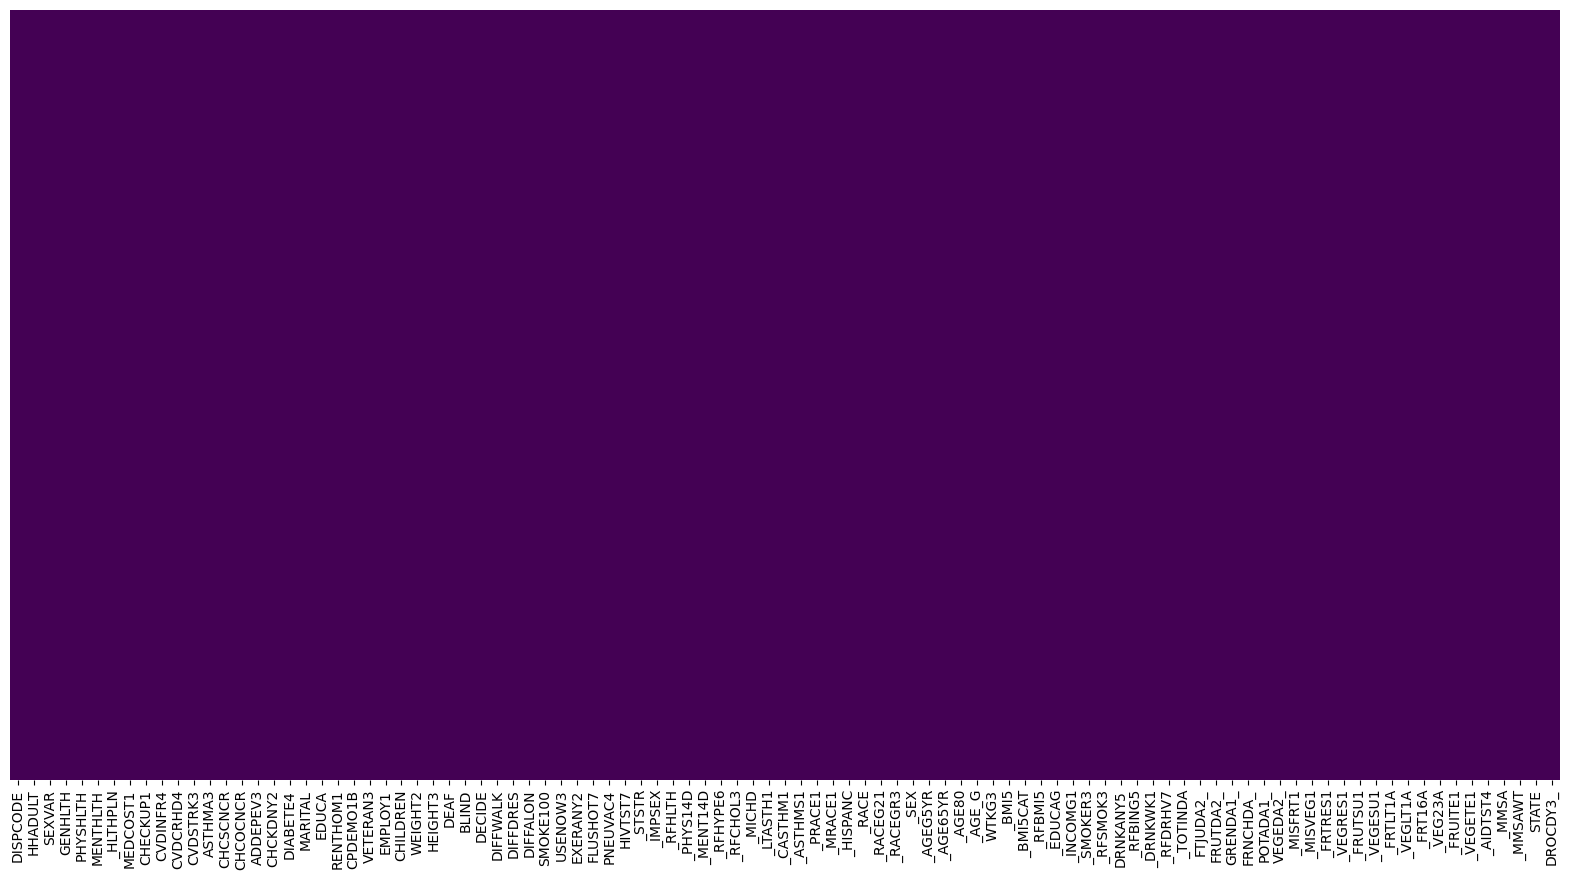

In [38]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [39]:
#Lets Generate A profile report of the cleaned data
profile = ProfileReport(processed_features_df,minimal=True,dark_mode=True)
profile.to_file(output_file="mydata/2019_Cleaned.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Export the processed df out to be split into training and validation data

In [40]:
processed_features_df.to_csv('mydata/MMSA2021_Cleaned.csv', index=False)